In [1]:
import sys
import os
sys.path.append("/home/kirilman/Project/asbestos/yolov5")
sys.path.append("/home/kirilman/Project/asbestos/")
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import cv2
import seaborn as sns
%matplotlib inline
from dataset.path_utils import get_files_from_dirs, get_paths_from_dirs
from pycocotools.coco import COCO
import pandas as pd
from dataset import load_txt
from yolov5.utils.general import xywhn2xyxy, xywh2xyxy, xyxy2xywh
from PIL import Image
import matplotlib.patches as patches
import scipy.stats as stats

In [2]:
def get_diag(coords):
    if isinstance(coords, np.ndarray) and len(coords.shape) == 2:
        x1 = coords[0,0]
        y1 = coords[0,1]
        x2 = coords[0,2]
        y2 = coords[0,3]
    else:
        x1,y1,x2,y2 = coords
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def get_bbox_size_arr(path_2_label, image_names = None):
    labels_files = get_paths_from_dirs([path_2_label],['txt'])
    if image_names:
        labels_files = list(filter(lambda x: True if str(x.name).split('.')[0] in image_names else False, labels_files))
    bbox_sizes = []
    for p in labels_files:
        data = np.loadtxt(p)
        if len(data.shape) > 1:
            bboxs = data[:,1:5]
        else:
            bboxs = data[1:5].reshape(1,-1)
        for i,box in enumerate(xywh2xyxy(bboxs)):
            bbox_sizes.append(get_diag(box))
    return np.array(bbox_sizes)
def ks_metric(a,b):
    r = stats.kstest(a, b)
    return {'statistic': r.statistic, 'pvalue': r.pvalue}

In [3]:
!python ../../yolov5/train.py --cfg yolov5m.yaml --data \
../../../dataset/detection_set2/data_simple.yaml --imgs 512 --epoch 5 --name ks --batch-size 4 --exist-ok \
--project ../../yolov5/runs/train/

wandb: Currently logged in as: kirilman. Use `wandb login --relogin` to force relogin
train: weights=../../yolov5/yolov5s.pt, cfg=yolov5m.yaml, data=../../../dataset/detection_set2/data_simple.yaml, hyp=../../yolov5/data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=4, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=../../yolov5/runs/train/, name=ks, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 64 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.2-216-g6e544d5f Python-3.9.12 torch-1.11.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5947MiB)



In [ ]:
log_train = {}
step = 5
for epoch in range(2,20):
    !python ../../yolov5/train.py --weights ../../yolov5/runs/train/ks/weights/last.pt --data \
    ../../../dataset/detection_set2/data_simple.yaml --imgs 512 --epoch {step} --name ks --batch-size 4 --exist-ok \
    --project ../../yolov5/runs/train/

    !python ../../yolov5/detect.py --weights ../../yolov5/runs/train/ks/weights/last.pt --source ../../../dataset/detection_set2/validation/ --imgs 256 \
    --save-txt --name ks --exist-ok
    
    predict_labels = get_bbox_size_arr('../../yolov5/runs/detect/ks/labels/')
    train_labels   = get_bbox_size_arr('../../../dataset/detection_set2/validation/')
    r = ks_metric(predict_labels, train_labels)
    log_train[epoch*step] = r
    
frame_log = pd.DataFrame(log_train).T
frame_log.to_csv('ks_log.csv')

wandb: Currently logged in as: kirilman. Use `wandb login --relogin` to force relogin
train: weights=../../yolov5/runs/train/ks/weights/last.pt, cfg=, data=../../../dataset/detection_set2/data_simple.yaml, hyp=../../yolov5/data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=4, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=../../yolov5/runs/train/, name=ks, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 64 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.2-216-g6e544d5f Python-3.9.12 torch-1.11.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 594

In [12]:
frame_log

,statistic,pvalue
10,0.574208,6.618515e-07
15,0.479775,5.242414e-13
20,0.446310,3.601767e-30
25,0.428947,2.303558e-49
30,0.430259,1.907824e-70
35,0.413814,4.337927e-77
40,0.399461,2.875195e-78
45,0.375050,7.095505e-75


<AxesSubplot:ylabel='Count'>

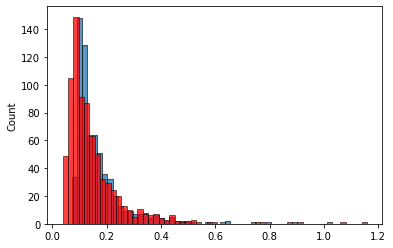

In [51]:
epoch = 27
arr = get_bbox_size_arr('../../yolov5/runs/detect/ks/labels/')
train_arr = get_bbox_size_arr('../../../dataset/detection_set2/validation/')
r = ks_metric(arr, train_arr)
log_train[epoch] = r
sns.histplot(arr)
sns.histplot(train_arr, color='red')

In [3]:
!python ../../yolov5/detect.py --help

usage: detect.py [-h] [--weights WEIGHTS [WEIGHTS ...]] [--source SOURCE]
                 [--data DATA] [--imgsz IMGSZ [IMGSZ ...]]
                 [--conf-thres CONF_THRES] [--iou-thres IOU_THRES]
                 [--max-det MAX_DET] [--device DEVICE] [--view-img]
                 [--save-txt] [--save-conf] [--save-crop] [--nosave]
                 [--classes CLASSES [CLASSES ...]] [--agnostic-nms]
                 [--augment] [--visualize] [--update] [--project PROJECT]
                 [--name NAME] [--exist-ok] [--line-thickness LINE_THICKNESS]
                 [--hide-labels] [--hide-conf] [--half] [--dnn]
                 [--vid-stride VID_STRIDE]

optional arguments:
  -h, --help            show this help message and exit
  --weights WEIGHTS [WEIGHTS ...]
                        model path or triton URL
  --source SOURCE       file/dir/URL/glob/screen/0(webcam)
  --data DATA           (optional) dataset.yaml path
  --imgsz IMGSZ [IMGSZ ...], --img IMGSZ [IMGSZ ...], --img-size